# Hinged beam

![](https://raw.githubusercontent.com/ibcmrocha/public/main/hingedbeam.png)

With:
- $EI = 8000$

Solve this problem. How do you deal with the hinges?

In [1]:
import numpy as np
import matplotlib as plt
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

> - The point load halfway node 3 and 4 can be modelled by adding another node
> - For the hinges, a beam element is derived with an undefined $\varphi$ at the left end and a corresponding end moment of $0$

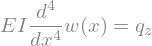

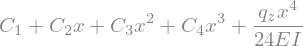

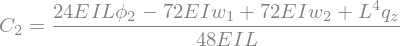

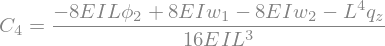

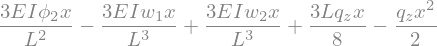

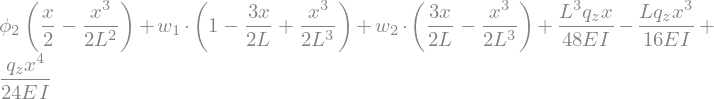

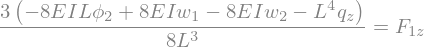

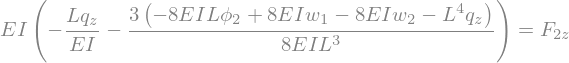

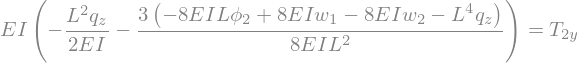

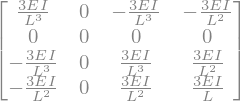

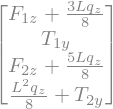

In [3]:
import sympy as sym
sym.init_printing()

EI, q_z, x = sym.symbols('EI, q_z, x')
L = sym.symbols('L',positive=True)
w = sym.Function('w')

ODE_bending = sym.Eq(w(x).diff(x, 4) *EI, q_z)
display(ODE_bending)

w = sym.dsolve(ODE_bending, w(x)).rhs
display(w)
phi = -w.diff(x)
kappa = phi.diff(x)
M = EI*kappa
V = M.diff(x)

w_1, w_2, phi_1, phi_2 = sym.symbols('w_1, w_2, phi_1, phi_2')
eq1 = sym.Eq(w.subs(x,0),w_1)
eq2 = sym.Eq(w.subs(x,L),w_2)
eq3 = sym.Eq(M.subs(x,0),0)
eq4 = sym.Eq(phi.subs(x,L),phi_2)
C_sol = sym.solve([eq1, eq2, eq3, eq4 ], sym.symbols('C1, C2, C3, C4'))
for key in C_sol:
    display(sym.Eq(key, C_sol[key]))

display(sym.collect(M.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2]))
display(sym.collect(w.subs(C_sol).expand(),[w_1,w_2,phi_1,phi_2]))

F_1_z, F_2_z, T_1_y, T_2_y = sym.symbols('F_1_z, F_2_z, T_1_y, T_2_y')

eq5 = sym.Eq(-V.subs(C_sol).subs(x,0), F_1_z)
eq6 = sym.Eq(V.subs(C_sol).subs(x,L), F_2_z)
eq7 = sym.Eq(-M.subs(C_sol).subs(x,0), T_1_y)
eq8 = sym.Eq(M.subs(C_sol).subs(x,L), T_2_y)
display(eq5, eq6, eq7, eq8)

A, b = sym.linear_eq_to_matrix([eq5,eq7, eq6, eq8], [w_1, phi_1, w_2, phi_2])
display(A,b)

> - So, the new stiffness matrix will be $\left[\begin{matrix}\frac{3 EI}{L^{3}} & 0 & - \frac{3 EI}{L^{3}} & - \frac{3 EI}{L^{2}}\\0 & 0 & 0 & 0\\- \frac{3 EI}{L^{3}} & 0 & \frac{3 EI}{L^{3}} & \frac{3 EI}{L^{2}}\\- \frac{3 EI}{L^{2}} & 0 & \frac{3 EI}{L^{2}} & \frac{3 EI}{L}\end{matrix}\right]$
> - The new equivalent load vector will be $\left[\begin{matrix} \frac{3 L q_{z}}{8}\\0\\\frac{5 L q_{z}}{8}\\\frac{L^{2} q_{z}}{8} \end{matrix}\right]$
> - The new expression for $M$ is $\frac{3 EI \phi_{2} x}{L^{2}} - \frac{3 EI w_{1} x}{L^{3}} + \frac{3 EI w_{2} x}{L^{3}} + \frac{3 L q_{z} x}{8} - \frac{q_{z} x^{2}}{2}$
> - The new expression for $w$ is $\phi_{2} \left(\frac{x}{2} - \frac{x^{3}}{2 L^{2}}\right) + w_{1} \cdot \left(1 - \frac{3 x}{2 L} + \frac{x^{3}}{2 L^{3}}\right) + w_{2} \cdot \left(\frac{3 x}{2 L} - \frac{x^{3}}{2 L^{3}}\right) + \frac{L^{3} q_{z} x}{48 EI} - \frac{L q_{z} x^{3}}{16 EI} + \frac{q_{z} x^{4}}{24 EI}
$
> - These have been implemented in the `hinged_element` class

In [4]:
mm.Node.clear()
mm.Element.clear()

EI = 8000

nodes = []

nodes.append(mm.Node(0,0))
nodes.append(mm.Node(3,0))
nodes.append(mm.Node(5,0))
nodes.append(mm.Node(7,0))
nodes.append(mm.Node(9,0))
nodes.append(mm.Node(13,0))
nodes.append(mm.Node(16,0))

elems = []

elems.append(mm.Element(nodes[0], nodes[1]))
elems.append(mm.hinged_element(nodes[1], nodes[2]))
elems.append(mm.Element(nodes[2], nodes[3]))
elems.append(mm.Element(nodes[3], nodes[4]))
elems.append(mm.hinged_element(nodes[4], nodes[5]))
elems.append(mm.Element(nodes[5], nodes[6]))

section = {}
section['EI'] = EI
for elem in elems:
    elem.set_section (section)

elems[2].add_distributed_load([0,8])
elems[3].add_distributed_load([0,8])

con = mm.Constrainer()

con.fix_dof (nodes[0], 1)
con.fix_dof (nodes[2], 1)
con.fix_node (nodes[6])

nodes[1].add_load ([0,15,0])
nodes[3].add_load ([0,5,0])
nodes[5].add_load ([0,10,0])

print(con)
for elem in elems:
    print(elem)

global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

Kff, Ff = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kff), Ff )
print(u)

print(con.support_reactions(global_k,u,global_f))

This constrainer has constrained the degrees of freedom: [1, 7, 18, 19, 20] with corresponding constrained values: [0, 0, 0, 0, 0])
Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=3,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0. 15.  0.]
Element connecting:
node #1:
 This node has:
 - x coordinate=3,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0. 15.  0.]
with node #2:
 This node has:
 - x coordinate=5,
 - z coordinate=0,
 - degrees of freedom=[6, 7, 8],
 - load vector=[ 0.          8.         -2.66666667]
Element connecting:
node #1:
 This node has:
 - x coordinate=5,
 - z coordinate=0,
 - degrees of freedom=[6, 7, 8],
 - load vector=[ 0.          8.         -2.66666667]
with node #2:
 This node has:
 - x coordinate=7,
 - z coordinate=0,
 - degrees of freedom=[9, 10, 11],
 - load vector=[ 0. 21.  

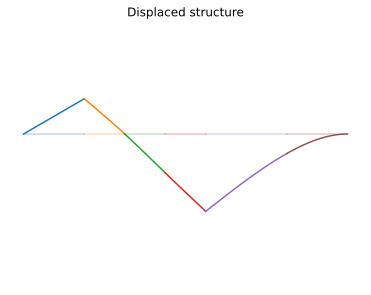

In [5]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_displaced(u_elem,num_points=51,global_c=True,scale=20)

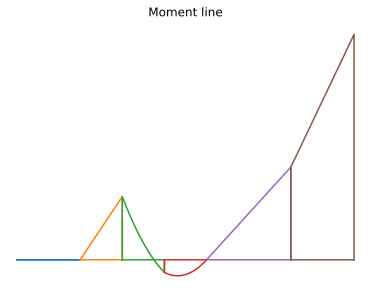

In [6]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_moment_diagram(u_elem,num_points=51,global_c=True,scale=0.1)